# Projet ARF : inpainting 
##### TREÜ Marc ; KARMIM Yannis

### Préambule : régression linéaire, régression ridge et LASSO

In [4]:
import numpy as np
import math
import sklearn
from sklearn.linear_model import LinearRegression,Ridge, RidgeCV, Lasso, LassoCV
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing


def load_usps(filename):
    with open(filename,"r") as f:
        f.readline()
        data =[ [float(x) for x in l.split()] for l in f if len(l.split())>2]
    tmp = np.array(data)
    return tmp[:,1:],tmp[:,0].astype(int)


# Chargement des données USPS. 

trainX, trainY = load_usps('data/USPS_train.txt')
testX, testY = load_usps('data/USPS_test.txt')

#### Regression Linéaire

In [5]:
def fit_linear_regression(n1,n2,dataX,dataY):
    
    """Compare deux classes représentant les nombres n1 et n2
    en utilisant une régression linéaire ."""

    indice_classe = np.where(np.in1d(dataY, [n1,n2]))
    X = dataX[indice_classe]
    Y = np.where(dataY[indice_classe] == n1, 1, -1)

    return LinearRegression(normalize=True).fit(X,Y)

In [6]:
# Choix des classes : 
n1 = 1
n2 = 7

reg = fit_linear_regression(n1,n2,trainX,trainY)

indice_classe = np.where(np.in1d(testY, [n1,n2]))
X_test = testX[indice_classe]
Y_test = np.where(testY[indice_classe] == n1, 1, -1)

Score calculer avec le coeficient de determination R²

In [7]:
reg.score(X_test, Y_test)

-5.4150241635465626e+19

Score calculé avec la methode plug-in

In [8]:
np.sum(np.sign(reg.predict(X_test)) == Y_test) / len(Y_test)

0.9708029197080292

In [9]:
def plugin_score(models, X_test, Y_test):
    return np.sum(np.sign(models.predict(X_test)) == Y_test) / len(Y_test)

#### Ridge Regression ( sans Cross Val ) 

In [10]:
def fit_ridge_regression(n1,n2,dataX,dataY,alpha=1.0):
    """Compare deux classes représentant les nombres n1 et n2
    en utilisant une Ridge Regression."""
    
    indice_classe = np.where(np.in1d(dataY, [n1,n2]))
    X = dataX[indice_classe]
    Y = np.where(dataY[indice_classe] == n1, 1, -1)

    return Ridge(alpha=alpha).fit(X,Y)

ridge = fit_ridge_regression(n1,n2,trainX,trainY,alpha=1.0)
print("score avec la ridge regression :", plugin_score(ridge, X_test, Y_test))

score avec la ridge regression : 0.9878345498783455


#### Ridge Regression ( avec Cross Val )

In [11]:
def fit_ridge_regressionCV(n1,n2,dataX,dataY,nb_cv = 10, verbose=False):
    """Compare deux classes représentant les nombres n1 et n2
    en utilisant une Ridge Regression avec Cross Val."""
    
    indice_classe = np.where(np.in1d(dataY, [n1,n2]))
    X = dataX[indice_classe]
    Y = np.where(dataY[indice_classe] == n1, 1, -1)
    
    clf = RidgeCV(alphas=(0.1, 1, 5, 10, 20), cv = nb_cv)
    clf.fit(X,Y)
    
    if verbose:
        print("Meilleur alpha trouvé par Cross Validation : ",clf.alpha_)
    
    return clf 

ridgeCV = fit_ridge_regressionCV(n1, n2, trainX, trainY, verbose=True)
print("score avec la ridge regression + cross validation :",plugin_score(ridgeCV, X_test, Y_test))

Meilleur alpha trouvé par Cross Validation :  20.0
score avec la ridge regression + cross validation : 0.9854014598540146


#### LASSO 

In [12]:
def fit_LASSO(n1,n2,dataX,dataY,alpha = 0.001):
    """Compare deux classes représentant les nombres n1 et n2
    en utilisant une Ridge Regression avec Cross Val."""
    
    indice_classe = np.where(np.in1d(dataY, [n1,n2]))
    X = dataX[indice_classe]
    Y = np.where(dataY[indice_classe] == n1, 1, -1)
    clf = Lasso(alpha = alpha)
    clf.fit(X,Y)
    
    return clf 

lasso = fit_LASSO(n1,n2,trainX,trainY,alpha=0.1)
print("score avec lasso regression :", plugin_score(lasso, X_test, Y_test))

score avec lasso regression : 0.9635036496350365


#### LASSO + Cross Validation

In [13]:
def fit_LASSO_CV(n1,n2,dataX,dataY,nb_cv = 10, verbose=False):
    """Compare deux classes représentant les nombres n1 et n2
    en utilisant une Ridge Regression avec Cross Val."""
    
    indice_classe = np.where(np.in1d(dataY, [n1,n2]))
    X = dataX[indice_classe]
    Y = np.where(dataY[indice_classe] == n1, 1, -1)
    
    clf = LassoCV(cv = nb_cv)
    clf.fit(X,Y)
    if verbose:
        print("Meilleur alpha trouvé par Cross Validation : ",clf.alpha_)
    
    return clf 

lassoCV = fit_LASSO_CV(n1, n2, trainX, trainY, verbose=True)
print("score avec lasso regression + cross validation :",plugin_score(lassoCV, X_test, Y_test))

Meilleur alpha trouvé par Cross Validation :  0.0014878791090701493
score avec lasso regression + cross validation : 0.9829683698296837


In [14]:
import itertools

def calcule_all_result(trainX, trainY, testX, testY):
    
    # Combinaison de tous les classifieur classe i vs classe j : [(1, 2), (1, 3), ...]
    combinaison = [i for i in itertools.combinations([(j) for j in range(10)], 2)]
    
    # On fit les 5 models pour chaque classe i vs classe j
    models_regression = [fit_linear_regression(n[0], n[1], trainX, trainY) for n in combinaison]
    
    models_ridge = [fit_ridge_regression(n[0], n[1], trainX, trainY) for n in combinaison]
    models_ridgeCV = [fit_ridge_regressionCV(n[0], n[1], trainX, trainY) for n in combinaison]
    
    models_lasso = [fit_LASSO(n[0],n[1], trainX, trainY) for n in combinaison]
    models_lassoCV = [fit_LASSO_CV(n[0],n[1], trainX, trainY) for n in combinaison]
    
    models = [models_regression, models_ridge, models_ridgeCV, models_lasso, models_lassoCV]
    
    score_models_regression = []
    score_models_ridge = []
    score_models_ridgeCV = []
    score_models_lasso = []
    score_models_lassoCV = [] 
    
    for n in range(len(combinaison)):
        n1, n2 = combinaison[n]
        indice_classe = np.where(np.in1d(testY, [n1,n2]))
        X = testX[indice_classe]
        Y = np.where(testY[indice_classe] == n1, 1, -1)
        
        score_models_regression.append(plugin_score(models_regression[n], X, Y))
        score_models_ridge.append(plugin_score(models_ridge[n], X, Y))
        score_models_ridgeCV.append(plugin_score(models_ridgeCV[n], X, Y))
        score_models_lasso.append(plugin_score(models_lasso[n], X, Y))
        score_models_lassoCV.append(plugin_score(models_lassoCV[n], X, Y))

    scores = [score_models_regression, score_models_ridge, score_models_ridgeCV, score_models_lasso, score_models_lassoCV] 
    
    return models, scores

In [17]:
models, scores = calcule_all_result(trainX, trainY, testX, testY)

In [18]:
def calcule_w_moyen(liste_modele):
    return sum(sum(abs(w) for w in liste_modele[i].coef_) / 256 for i in range(len(liste_modele))) / len(liste_modele)

def calcule_w_var(liste_modele):
    return np.var([[w for w in liste_modele[i].coef_ ] for i in range(len(liste_modele))])
    
def calcule_nombre_w_null(liste_modele):
    return sum(len(np.where(liste_modele[i].coef_ == 0)[0]) for i in range(len(liste_modele))) / len(liste_modele)

def calcule_score_moy(liste_score):
    return sum(liste_score) / len(liste_score)
    
def calcule_all(modeles, scores):
    return calcule_score_moy(scores), calcule_w_moyen(modeles), calcule_w_var(modeles), calcule_nombre_w_null(modeles)

                            

In [19]:
resultat_reg = calcule_all(models[0], scores[0])
resultat_ridge = calcule_all(models[1], scores[1])
resultat_ridgeCV = calcule_all(models[2], scores[2])
resultat_lasso = calcule_all(models[3], scores[3])
resultat_lassoCV = calcule_all(models[4], scores[4])

resultat_all = [calcule_all(models[i], scores[i]) for i in range(5)]

def print_resultat(resultat):
    nom_reg = {0:"Regression simplement avec MSE", 1:"Regression avec regularisation l2 (Ridge)", 2:"Regression avec regularisation l2 + cross validation"
    ,3:"Regression avec regularisation l1 (Lasso)",4:"Regression avec regularisation l1 (Lasso) + cross validation"}
    
    for i in range(5):
        print(nom_reg[i],":\n\t\tscore moyenne =", resultat[i][0], "\n\t\tpoid moyen des w =", resultat[i][1]
              , "\n\t\tvariance moyenne des w =", resultat[i][2], "\n\t\tnombre moyen de w a 0 =", resultat[i][3], "\n")


### Résultat

In [20]:
print_resultat(resultat_all)

Regression simplement avec MSE :
		score moyenne = 0.9726377952540973 
		poid moyen des w = 554842134089.6156 
		variance moyenne des w = 8.415495716396342e+26 
		nombre moyen de w a 0 = 0.37777777777777777 

Regression avec regularisation l2 (Ridge) :
		score moyenne = 0.9775118888513816 
		poid moyen des w = 0.05697677217882317 
		variance moyenne des w = 0.006887798552883184 
		nombre moyen de w a 0 = 1.5555555555555556 

Regression avec regularisation l2 + cross validation :
		score moyenne = 0.9794803574409355 
		poid moyen des w = 0.02928553188640165 
		variance moyenne des w = 0.0015506889223157704 
		nombre moyen de w a 0 = 1.5555555555555556 

Regression avec regularisation l1 (Lasso) :
		score moyenne = 0.9786068623246679 
		poid moyen des w = 0.022131600613787345 
		variance moyenne des w = 0.001833394941678783 
		nombre moyen de w a 0 = 110.97777777777777 

Regression avec regularisation l1 (Lasso) + cross validation :
		score moyenne = 0.9786179799146486 
		poid moyen des 

Tous les modèles ont des performances similaire, c'est à dire au alentour de 97% de bonne classification,
mais c'est avec les poids de W apris que la différence est la plus flagrante. Alors que l'on a un W moyenne a 500 millard avec une variance en 10^26 pour la regression sans pénalisation. On tombe à un W moyen inferieur a 0.1 et une variance inferieur a 0.01 pour les normes L1 et L2.

Aussi, l'avantage pricipal de la regularisation Lasso par rapport à Ridge est le nombre de composante W qui devienne nulle, ainsi on a en moyenne 143 W qui devienne egale à 0, sur nos 256 dimension cela represente près de 55% pixels qu'on ne prend plus en consideration pour la classification. La matrice des poids pour Lasso est donc beaucoup plus sparce


### LASSO et Inpainting

##### Fonction preliminaire

In [44]:
import matplotlib.pyplot as plt
from matplotlib.colors import rgb_to_hsv, hsv_to_rgb

def read_im(fn):
    image = plt.imread(fn)
    return rgb_to_hsv(image)

def show_im(fn):
    plt.imshow(hsv_to_rgb(fn))
    
def get_patch(i,j,h,im):
    return im[]

array([[[0.01980199, 0.44690266, 0.8862745 ],
        [0.01980199, 0.44690266, 0.8862745 ],
        [0.00740741, 0.40358743, 0.8745098 ],
        ...,
        [0.04012347, 0.4695652 , 0.9019608 ],
        [0.03003004, 0.5022624 , 0.8666667 ],
        [0.01363636, 0.55      , 0.78431374]],

       [[0.01980199, 0.44690266, 0.8862745 ],
        [0.01980199, 0.44690266, 0.8862745 ],
        [0.00740741, 0.40358743, 0.8745098 ],
        ...,
        [0.04012347, 0.4695652 , 0.9019608 ],
        [0.03003004, 0.5022624 , 0.8666667 ],
        [0.01363636, 0.55      , 0.78431374]],

       [[0.01980199, 0.44690266, 0.8862745 ],
        [0.01980199, 0.44690266, 0.8862745 ],
        [0.00740741, 0.40358743, 0.8745098 ],
        ...,
        [0.04012347, 0.4695652 , 0.9019608 ],
        [0.03003004, 0.5022624 , 0.8666667 ],
        [0.01363636, 0.55      , 0.78431374]],

       ...,

       [[0.9778761 , 0.6384181 , 0.69411767],
        [0.9778761 , 0.6384181 , 0.69411767],
        [0.9746032 , 0

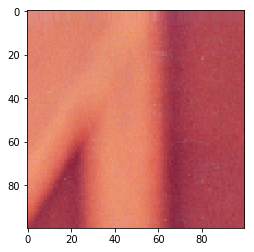

In [51]:
lena = read_im('data/lena.png')

show_im(lena[0:100,0:100,0:100])
lena[:100]